# Advanced Machine Learning - programming assignment 3

*Due: Friday January 12*

*Grading: 10 points total*

**Please fill in:**
* Panagiotis Aronis (9398333)
* Martino Fabiani (2257742)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return x, y, z

num_samples_obs = 1000

x_obs, y_obs, z_obs = generate_observational_data(num_samples_obs)

C:\Users\panaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


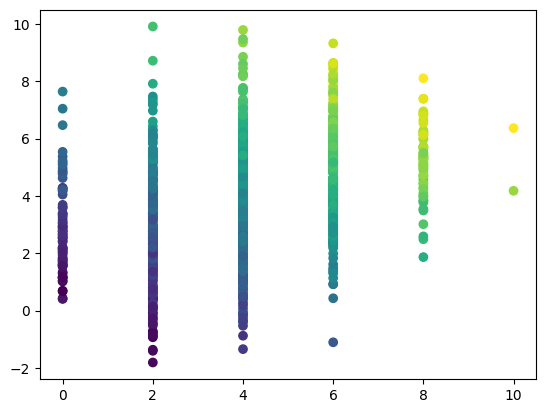

In [2]:
plt.scatter(x_obs, y_obs, c=z_obs)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

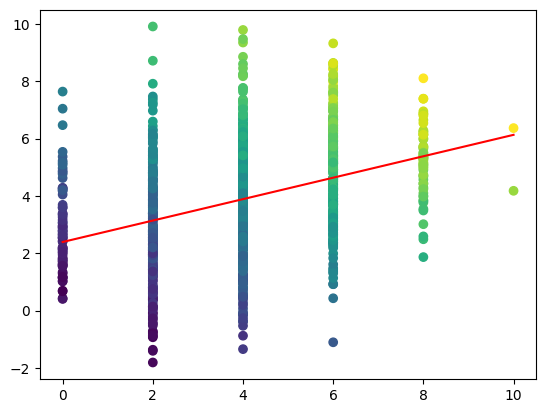

In [3]:
model1 = linear_model.LinearRegression()
model1.fit(x_obs.reshape(-1, 1), y_obs)

x_lin1 = np.linspace(0, 10, 100)
y_lin1 = model1.predict(x_lin1.reshape(-1, 1))

plt.scatter(x_obs, y_obs, c=z_obs)
plt.plot(x_lin1, y_lin1, color='red')
plt.show()

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

The given structural causal model contains three endogenous variables, namely, the treatment, X, the outcome, Y, and the genetic information, Z. Each of these endogenous variables has one exogenous parent, which is independent from each other and, thus, omitted from our analysis (bayesian network).

The genetic information, Z, has no direct causes among the other endogenous variables, X and Y. This makes sense as the genetic information of an individual can not change as a result of the treatment they receive or the outcome of this treatment. However, the genetic information, Z, is a direct cause of the treatment, X. In general, doctors may decide the type and amount of drug dosage given the particular genetic characteristics of a patient. Finally, the outcome, Y, has both the genetic information, Z, and the treatment, X, as direct causes. Some patients might be more likely than others to recover because of their genetic characteristics, and, of course, the dosage of the drug they receive as treatment has also an effect on their recovery.

The above direct causes are shown as a graph of the SCM in the provided image 'scm_graph_observational.png'.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [4]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Z and Y use the same structural equations, while X is instead equal to the provided vector.
    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples)
    return x, y, z

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [5]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
x_exp, y_exp, z_exp = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

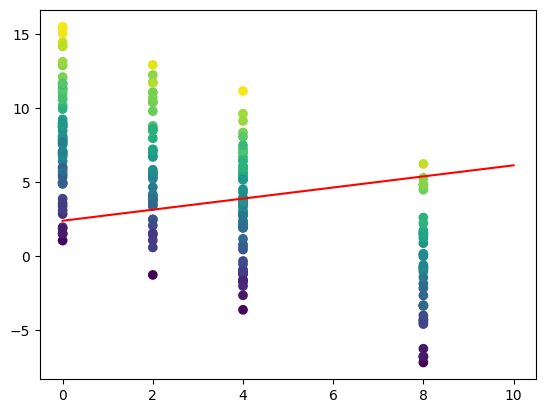

In [6]:
plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(x_lin1, y_lin1, color='red')
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [7]:
y_exp_pred1 = model1.predict(x_exp.reshape(-1, 1))

rmse1 = mean_squared_error(y_exp, y_exp_pred1, squared=False)

print(f'Root mean squared error without inverse probability weighting: {rmse1:.3f}')

Root mean squared error without inverse probability weighting: 5.547


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

The original SCM was described above and its graph is shown in image 'scm_graph_observational.png'. The product decomposition is then: $ P(X=x, Y=y, Z=z) = P(X=x | Z=z) P(Y=y | X=x, Z=z) P(Z=z) $.

After performing the intervention on X, the modified SCM discards the structural equation of X, so the resulting SCM graph is missing the incoming edges to the variable X, as it is shown in image 'scm_graph_experimental.png'. The new product decomposition is then: $ P(X=x, Y=y, Z=z) = P(X=x) P(Y=y | X=x, Z=z) P(Z=z) $.

The factors for Y and Z variables are the same in the two decompositions because the structural equations for these variables are unmodified. However, the factor for variable X, $ P(X=x | Z=z) $, is replaced by $ P(X=x) $ in the product decomposition for the experimental distribution reflecting the intervention on X.

The linear model we used to predict the variable Y from the variable X estimates the conditional distribution $ P(Y=y | X=x) $. So, this conditional distribution should be the same after intervening on X, $ P(Y=y | do(X=x)) $, in order to accurately predict Y from X in the experimental data too. However, this is not the case, as it can be seen by the difference in the product decompositions for the two joint distributions given above.

**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

Observing the graph of the modified SCM ('scm_graph_experimental.png') after intervening on variable X, we see that variables X and Z are now d-separated (the only path between them is passing through variable Y, which is a collider in the path, so the path is closed). As a result of the Markov property, variables X and Z are (marginally) independent in the experimental data: $ P(X=x, Z=z) = P(X=x) P(Z=z) $. Below we plot the distribution of Z for each value of the variable X in the experimental data. These distributions, $ P(Z=z | X=x) $, are almost identical and same with the unconditional distribution $ P(Z=z) $, thus illustrating this independence.

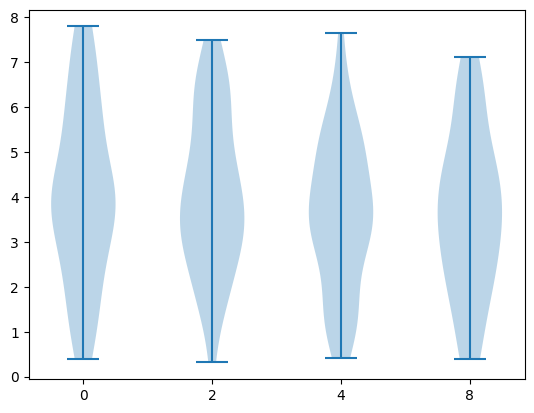

In [8]:
plt.violinplot([[z for x, z in zip(x_exp, z_exp) if x == x_i] for x_i in sorted(set(x_exp))])
plt.xticks(range(1, 5), sorted(set(x_exp)))
plt.show()

**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [9]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
reg_logistic.fit(z_obs.reshape(-1, 1), x_obs)

# softmax probabilities for all X values for each sample Z
probs = reg_logistic.predict_proba(z_obs.reshape(-1, 1))

# inverse probability weights, reciprocal of the probability of the correct X value for each sample Z
weights = 1 / probs[range(num_samples_obs), x_obs // 2]

**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

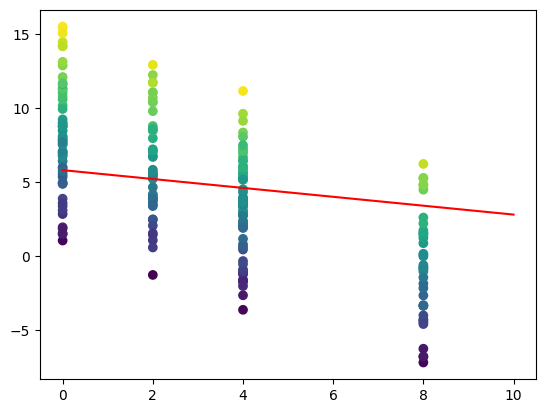

In [10]:
model2 = linear_model.LinearRegression()
model2.fit(x_obs.reshape(-1, 1), y_obs, weights)

x_lin2 = np.linspace(0, 10, 100)
y_lin2 = model2.predict(x_lin2.reshape(-1, 1))

plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(x_lin2, y_lin2, color='red')
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [11]:
y_exp_pred2 = model2.predict(x_exp.reshape(-1, 1))

rmse2 = mean_squared_error(y_exp, y_exp_pred2, squared=False)

print(f'Root mean squared error with inverse probability weighting: {rmse2:.3f}')

Root mean squared error with inverse probability weighting: 4.240


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).